In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from PIL import Image
from tensorflow.keras.utils import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from s3helper import *
from DataGenerator import *
from ModelWrapper import *

In [12]:
# path = Path("UTKFace")
# filenames = list(map(lambda x: x.name, path.glob('*.jpg')))
# print(len(filenames))
# print(filenames[:3])
DATASETS_BUCKET = "se-project-ext-datasets"
OUTPUTS_BUCKET = "se-project-ext-outputs"

s3_helper = S3Helper(DATASETS_BUCKET, OUTPUTS_BUCKET)
filenames = s3_helper.list_objects(DATASETS_BUCKET, "UTKFace")
filenames = [filee.split("/")[-1] for filee in filenames]
print(len(filenames))


2370


In [13]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])

image_path

['26_1_3_20170119193111002.jpg.chip.jpg',
 '53_0_1_20170116191725055.jpg.chip.jpg',
 '32_0_1_20170117140609238.jpg.chip.jpg',
 '22_0_3_20170119162917829.jpg.chip.jpg',
 '14_0_0_20170110225116744.jpg.chip.jpg',
 '1_0_2_20161219140952943.jpg.chip.jpg',
 '40_0_0_20170104174309067.jpg.chip.jpg',
 '42_1_0_20170117163607667.jpg.chip.jpg',
 '39_0_3_20170119203757237.jpg.chip.jpg',
 '30_0_0_20170117003435100.jpg.chip.jpg',
 '67_0_0_20170109002906472.jpg.chip.jpg',
 '1_0_3_20161219225633088.jpg.chip.jpg',
 '30_0_1_20170113133323665.jpg.chip.jpg',
 '32_1_0_20170109141918401.jpg.chip.jpg',
 '26_1_1_20170116023939164.jpg.chip.jpg',
 '13_0_2_20170117152653604.jpg.chip.jpg',
 '26_1_0_20170117152703723.jpg.chip.jpg',
 '26_1_2_20170116184840727.jpg.chip.jpg',
 '11_1_0_20170109205216790.jpg.chip.jpg',
 '26_1_2_20170116180854138.jpg.chip.jpg',
 '50_0_1_20170117154528349.jpg.chip.jpg',
 '35_0_2_20170119180256157.jpg.chip.jpg',
 '55_0_3_20170119183211767.jpg.chip.jpg',
 '43_1_0_20170117155108211.jpg.chip.

In [14]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_path, age_labels, gender_labels
df.head()

,image,age,gender
0,26_1_3_20170119193111002.jpg.chip.jpg,26,1
1,53_0_1_20170116191725055.jpg.chip.jpg,53,0
2,32_0_1_20170117140609238.jpg.chip.jpg,32,0
3,22_0_3_20170119162917829.jpg.chip.jpg,22,0
4,14_0_0_20170110225116744.jpg.chip.jpg,14,0


In [15]:
gender_dict = {0:"Male",1:"Female"}
df = df.astype({'age':'float32', 'gender': 'int32'})
print(df.dtypes)

# img = Image.open("UTKFace/"+df.image[1])
# img = s3_helper.get_img("UTKFace/"+df.image[1])
# print(type(img))
# plt.imshow(img)
# sns.distplot(df.age)

image      object
age       float32
gender      int32
dtype: object


In [16]:
# files = df.iloc[0:20]
# print(len(files))
# plt.figure(figsize=(15,15))
# for index, file, age, gender in files.itertuples():
#     plt.subplot(5,5, index+1)
#     img = s3_helper.get_img("UTKFace/"+file)
#     img = np.array(img)
#     plt.imshow(img)
#     plt.title(f"Age: {age} Gender: {gender_dict[gender]}")
#     plt.axis('off')

In [17]:
train, test = train_test_split(df, test_size=0.95, random_state=42)
train.head()
train.shape

(118, 3)

In [18]:
batch_size = 10
img_size = (128, 128)
n_channels = 1

# Instantiate the data generator
train_generator = S3DataGenerator(
    bucket_name=DATASETS_BUCKET,
    file_keys=train['image'].tolist(),
    labels_age=train['age'].tolist(),
    labels_gender=train['gender'].tolist(),
    batch_size=batch_size,
    img_size=img_size,
    n_channels=n_channels,
    shuffle=True
)
x_train = []
for file in train.image:
    img = s3_helper.get_img("UTKFace/"+file, greyscale= True)
    img = img.resize((128,128), Image.LANCZOS)
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 128,128,1)
x_train.shape
x_train = x_train/255
y_gender = np.array(train.gender)
y_age = np.array(train.age)

input_size = (128,128,1)

x_train.shape

(118, 128, 128, 1)

In [19]:
inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu', kernel_initializer = glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [20]:
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=[['accuracy'], ['accuracy']])

model.summary()

# model_history = model.fit(x=x_train, y=[y_gender, y_age], batch_size = 10, epochs=20, validation_split= 0.1)
model_history = model.fit(train_generator, epochs=10, verbose=1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 126, 126, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

INFO:Processing batch of 10 images.


Epoch 1/10


2024-12-02 13:04:12.029757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-02 13:04:12.036665: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 17s - loss: 29.6826 - gender_output_loss: 0.7347 - age_output_loss: 28.9479 - gender_output_accuracy: 0.4000 - age_output_accuracy: 0.0000e+00

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 9s - loss: 26.0308 - gender_output_loss: 2.8382 - age_output_loss: 23.1926 - gender_output_accuracy: 0.5000 - age_output_accuracy: 0.0000e+00 

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 21.4536 - gender_output_loss: 2.1054 - age_output_loss: 19.3482 - gender_output_accuracy: 0.5667 - age_output_accuracy: 0.0000e+00

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 29.8130 - gender_output_loss: 2.4116 - age_output_loss: 27.4013 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.0250    

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 28.0837 - gender_output_loss: 2.1459 - age_output_loss: 25.9379 - gender_output_accuracy: 0.6200 - age_output_accuracy: 0.0400

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 27.7249 - gender_output_loss: 1.9251 - age_output_loss: 25.7999 - gender_output_accuracy: 0.6333 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 26.7746 - gender_output_loss: 1.7901 - age_output_loss: 24.9846 - gender_output_accuracy: 0.5714 - age_output_accuracy: 0.0429

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 25.3959 - gender_output_loss: 1.6345 - age_output_loss: 23.7614 - gender_output_accuracy: 0.5750 - age_output_accuracy: 0.0625

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 25.3137 - gender_output_loss: 1.5980 - age_output_loss: 23.7157 - gender_output_accuracy: 0.5556 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 23.6937 - gender_output_loss: 1.5457 - age_output_loss: 22.1480 - gender_output_accuracy: 0.5636 - age_output_accuracy: 0.0545
Epoch 2/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 13s - loss: 18.0067 - gender_output_loss: 0.8439 - age_output_loss: 17.1628 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0000e+00

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 11s - loss: 17.4987 - gender_output_loss: 1.0619 - age_output_loss: 16.4368 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.1000    

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 10s - loss: 18.8681 - gender_output_loss: 1.2587 - age_output_loss: 17.6094 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 9s - loss: 18.6933 - gender_output_loss: 1.0980 - age_output_loss: 17.5953 - gender_output_accuracy: 0.6500 - age_output_accuracy: 0.0500 

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 18.2676 - gender_output_loss: 1.0843 - age_output_loss: 17.1833 - gender_output_accuracy: 0.5800 - age_output_accuracy: 0.0600

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 17.6280 - gender_output_loss: 1.0530 - age_output_loss: 16.5750 - gender_output_accuracy: 0.5833 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 16.6503 - gender_output_loss: 1.0078 - age_output_loss: 15.6425 - gender_output_accuracy: 0.5714 - age_output_accuracy: 0.0571

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 16.6539 - gender_output_loss: 0.9777 - age_output_loss: 15.6762 - gender_output_accuracy: 0.5750 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 16.1104 - gender_output_loss: 0.9509 - age_output_loss: 15.1595 - gender_output_accuracy: 0.5778 - age_output_accuracy: 0.0778

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 15.8727 - gender_output_loss: 0.9515 - age_output_loss: 14.9213 - gender_output_accuracy: 0.5273 - age_output_accuracy: 0.0636
Epoch 3/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 12s - loss: 19.9796 - gender_output_loss: 0.7544 - age_output_loss: 19.2252 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.0000e+00

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 11s - loss: 16.8051 - gender_output_loss: 0.8974 - age_output_loss: 15.9077 - gender_output_accuracy: 0.4500 - age_output_accuracy: 0.1500    

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 17.7038 - gender_output_loss: 0.8292 - age_output_loss: 16.8746 - gender_output_accuracy: 0.4667 - age_output_accuracy: 0.1000 

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 16.7777 - gender_output_loss: 0.7794 - age_output_loss: 15.9983 - gender_output_accuracy: 0.4750 - age_output_accuracy: 0.0750

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 18.8572 - gender_output_loss: 0.7559 - age_output_loss: 18.1013 - gender_output_accuracy: 0.5000 - age_output_accuracy: 0.0800

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 18.1372 - gender_output_loss: 0.7218 - age_output_loss: 17.4155 - gender_output_accuracy: 0.5333 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 17.6031 - gender_output_loss: 0.7259 - age_output_loss: 16.8771 - gender_output_accuracy: 0.5429 - age_output_accuracy: 0.0714

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 16.8409 - gender_output_loss: 0.6815 - age_output_loss: 16.1594 - gender_output_accuracy: 0.5875 - age_output_accuracy: 0.0750

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 16.7657 - gender_output_loss: 0.7083 - age_output_loss: 16.0574 - gender_output_accuracy: 0.5889 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


11/11 [==============================] - 13s 1s/step - loss: 16.1581 - gender_output_loss: 0.7109 - age_output_loss: 15.4473 - gender_output_accuracy: 0.5727 - age_output_accuracy: 0.0636
Epoch 4/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 14s - loss: 18.1929 - gender_output_loss: 0.4576 - age_output_loss: 17.7352 - gender_output_accuracy: 0.8000 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 11s - loss: 16.3583 - gender_output_loss: 0.6630 - age_output_loss: 15.6953 - gender_output_accuracy: 0.6500 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 14.4811 - gender_output_loss: 0.6638 - age_output_loss: 13.8172 - gender_output_accuracy: 0.6333 - age_output_accuracy: 0.0333 

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 14.6565 - gender_output_loss: 0.6049 - age_output_loss: 14.0516 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 16.2540 - gender_output_loss: 0.5700 - age_output_loss: 15.6840 - gender_output_accuracy: 0.7200 - age_output_accuracy: 0.0400

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 5s - loss: 15.4383 - gender_output_loss: 0.5911 - age_output_loss: 14.8473 - gender_output_accuracy: 0.7167 - age_output_accuracy: 0.0333

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 15.5501 - gender_output_loss: 0.5848 - age_output_loss: 14.9653 - gender_output_accuracy: 0.7143 - age_output_accuracy: 0.0286

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 15.1940 - gender_output_loss: 0.5934 - age_output_loss: 14.6006 - gender_output_accuracy: 0.7250 - age_output_accuracy: 0.0250

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 15.3285 - gender_output_loss: 0.6116 - age_output_loss: 14.7169 - gender_output_accuracy: 0.7111 - age_output_accuracy: 0.0333

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 15.0421 - gender_output_loss: 0.6376 - age_output_loss: 14.4045 - gender_output_accuracy: 0.6727 - age_output_accuracy: 0.0545
Epoch 5/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 13s - loss: 12.0675 - gender_output_loss: 0.4870 - age_output_loss: 11.5805 - gender_output_accuracy: 0.9000 - age_output_accuracy: 0.2000

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 10s - loss: 15.3975 - gender_output_loss: 0.5741 - age_output_loss: 14.8234 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.1500

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 13.7239 - gender_output_loss: 0.5108 - age_output_loss: 13.2131 - gender_output_accuracy: 0.7667 - age_output_accuracy: 0.1000 

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 14.6179 - gender_output_loss: 0.6318 - age_output_loss: 13.9861 - gender_output_accuracy: 0.6500 - age_output_accuracy: 0.0750

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 14.2158 - gender_output_loss: 0.5980 - age_output_loss: 13.6178 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0600

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 15.1681 - gender_output_loss: 0.5956 - age_output_loss: 14.5725 - gender_output_accuracy: 0.6833 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 14.8023 - gender_output_loss: 0.5744 - age_output_loss: 14.2278 - gender_output_accuracy: 0.7143 - age_output_accuracy: 0.0571

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 15.5463 - gender_output_loss: 0.5857 - age_output_loss: 14.9605 - gender_output_accuracy: 0.6875 - age_output_accuracy: 0.0625

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 14.7957 - gender_output_loss: 0.5918 - age_output_loss: 14.2039 - gender_output_accuracy: 0.6889 - age_output_accuracy: 0.0556

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 14.7229 - gender_output_loss: 0.5952 - age_output_loss: 14.1277 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0545
Epoch 6/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 13s - loss: 19.6159 - gender_output_loss: 0.5596 - age_output_loss: 19.0562 - gender_output_accuracy: 0.8000 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 10s - loss: 15.1756 - gender_output_loss: 0.4540 - age_output_loss: 14.7216 - gender_output_accuracy: 0.8000 - age_output_accuracy: 0.2000

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 13.9879 - gender_output_loss: 0.5076 - age_output_loss: 13.4803 - gender_output_accuracy: 0.7333 - age_output_accuracy: 0.1667 

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 15.0595 - gender_output_loss: 0.4864 - age_output_loss: 14.5731 - gender_output_accuracy: 0.7500 - age_output_accuracy: 0.1250

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 14.0246 - gender_output_loss: 0.4880 - age_output_loss: 13.5366 - gender_output_accuracy: 0.7200 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 13.6943 - gender_output_loss: 0.6061 - age_output_loss: 13.0882 - gender_output_accuracy: 0.6667 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 13.4805 - gender_output_loss: 0.6022 - age_output_loss: 12.8783 - gender_output_accuracy: 0.6714 - age_output_accuracy: 0.0857

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 12.7468 - gender_output_loss: 0.5927 - age_output_loss: 12.1541 - gender_output_accuracy: 0.6750 - age_output_accuracy: 0.0750

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 13.1915 - gender_output_loss: 0.5861 - age_output_loss: 12.6054 - gender_output_accuracy: 0.6667 - age_output_accuracy: 0.0778

INFO:Processing batch of 10 images.


11/11 [==============================] - 13s 1s/step - loss: 14.2814 - gender_output_loss: 0.5721 - age_output_loss: 13.7093 - gender_output_accuracy: 0.6909 - age_output_accuracy: 0.0636
Epoch 7/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 12s - loss: 11.8234 - gender_output_loss: 0.7337 - age_output_loss: 11.0897 - gender_output_accuracy: 0.4000 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 10s - loss: 10.5303 - gender_output_loss: 0.5967 - age_output_loss: 9.9336 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.0500 

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 11.4166 - gender_output_loss: 0.5227 - age_output_loss: 10.8939 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 12.4989 - gender_output_loss: 0.5282 - age_output_loss: 11.9707 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 13.4321 - gender_output_loss: 0.5275 - age_output_loss: 12.9046 - gender_output_accuracy: 0.7200 - age_output_accuracy: 0.0400

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 14.2380 - gender_output_loss: 0.5261 - age_output_loss: 13.7119 - gender_output_accuracy: 0.7167 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 15.7461 - gender_output_loss: 0.5454 - age_output_loss: 15.2008 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0571

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 15.7390 - gender_output_loss: 0.5506 - age_output_loss: 15.1883 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 15.7205 - gender_output_loss: 0.5388 - age_output_loss: 15.1816 - gender_output_accuracy: 0.7333 - age_output_accuracy: 0.0556

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 15.0700 - gender_output_loss: 0.5290 - age_output_loss: 14.5410 - gender_output_accuracy: 0.7636 - age_output_accuracy: 0.0636
Epoch 8/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 12s - loss: 12.2500 - gender_output_loss: 0.6704 - age_output_loss: 11.5796 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.2000

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 10s - loss: 15.9637 - gender_output_loss: 0.6815 - age_output_loss: 15.2821 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 17.3264 - gender_output_loss: 0.6518 - age_output_loss: 16.6746 - gender_output_accuracy: 0.6000 - age_output_accuracy: 0.0667 

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 16.4302 - gender_output_loss: 0.5754 - age_output_loss: 15.8547 - gender_output_accuracy: 0.6750 - age_output_accuracy: 0.0750

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 16.2853 - gender_output_loss: 0.5565 - age_output_loss: 15.7288 - gender_output_accuracy: 0.7200 - age_output_accuracy: 0.0800

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 17.6114 - gender_output_loss: 0.5473 - age_output_loss: 17.0642 - gender_output_accuracy: 0.7333 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 17.7766 - gender_output_loss: 0.5462 - age_output_loss: 17.2304 - gender_output_accuracy: 0.7143 - age_output_accuracy: 0.0714

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 18.1778 - gender_output_loss: 0.5489 - age_output_loss: 17.6290 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0625

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 18.1191 - gender_output_loss: 0.5388 - age_output_loss: 17.5803 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 17.1287 - gender_output_loss: 0.5348 - age_output_loss: 16.5939 - gender_output_accuracy: 0.7182 - age_output_accuracy: 0.0636
Epoch 9/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 13s - loss: 18.9264 - gender_output_loss: 0.4159 - age_output_loss: 18.5105 - gender_output_accuracy: 0.8000 - age_output_accuracy: 0.0000e+00

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 11s - loss: 15.1781 - gender_output_loss: 0.5156 - age_output_loss: 14.6624 - gender_output_accuracy: 0.8000 - age_output_accuracy: 0.0500    

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 10s - loss: 16.9629 - gender_output_loss: 0.4668 - age_output_loss: 16.4962 - gender_output_accuracy: 0.8333 - age_output_accuracy: 0.0333

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 9s - loss: 14.8525 - gender_output_loss: 0.4572 - age_output_loss: 14.3953 - gender_output_accuracy: 0.8500 - age_output_accuracy: 0.0750 

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 14.2509 - gender_output_loss: 0.5049 - age_output_loss: 13.7460 - gender_output_accuracy: 0.7600 - age_output_accuracy: 0.0600

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 6s - loss: 15.5022 - gender_output_loss: 0.4825 - age_output_loss: 15.0198 - gender_output_accuracy: 0.8000 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 5s - loss: 14.7583 - gender_output_loss: 0.4959 - age_output_loss: 14.2623 - gender_output_accuracy: 0.7714 - age_output_accuracy: 0.0429

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 14.9272 - gender_output_loss: 0.4931 - age_output_loss: 14.4340 - gender_output_accuracy: 0.7625 - age_output_accuracy: 0.0625

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 14.7914 - gender_output_loss: 0.4766 - age_output_loss: 14.3148 - gender_output_accuracy: 0.7778 - age_output_accuracy: 0.0556

INFO:Processing batch of 10 images.


11/11 [==============================] - 14s 1s/step - loss: 14.8935 - gender_output_loss: 0.5230 - age_output_loss: 14.3705 - gender_output_accuracy: 0.7455 - age_output_accuracy: 0.0636
Epoch 10/10


INFO:Processing batch of 10 images.
INFO:Processing batch of 10 images.


 1/11 [=>............................] - ETA: 14s - loss: 15.9686 - gender_output_loss: 0.4705 - age_output_loss: 15.4982 - gender_output_accuracy: 0.9000 - age_output_accuracy: 0.1000

INFO:Processing batch of 10 images.


 2/11 [====>.........................] - ETA: 10s - loss: 14.6368 - gender_output_loss: 0.5282 - age_output_loss: 14.1086 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 3/11 [=======>......................] - ETA: 9s - loss: 12.0838 - gender_output_loss: 0.6053 - age_output_loss: 11.4786 - gender_output_accuracy: 0.6667 - age_output_accuracy: 0.0333 

INFO:Processing batch of 10 images.


 4/11 [=========>....................] - ETA: 8s - loss: 11.4329 - gender_output_loss: 0.5794 - age_output_loss: 10.8535 - gender_output_accuracy: 0.6500 - age_output_accuracy: 0.0250

INFO:Processing batch of 10 images.


 5/11 [============>.................] - ETA: 7s - loss: 12.3710 - gender_output_loss: 0.6038 - age_output_loss: 11.7672 - gender_output_accuracy: 0.6400 - age_output_accuracy: 0.0800

INFO:Processing batch of 10 images.


 6/11 [===============>..............] - ETA: 5s - loss: 12.7756 - gender_output_loss: 0.5759 - age_output_loss: 12.1997 - gender_output_accuracy: 0.6667 - age_output_accuracy: 0.0667

INFO:Processing batch of 10 images.


 7/11 [==================>...........] - ETA: 4s - loss: 12.7987 - gender_output_loss: 0.5439 - age_output_loss: 12.2548 - gender_output_accuracy: 0.7000 - age_output_accuracy: 0.0571

INFO:Processing batch of 10 images.


 8/11 [====================>.........] - ETA: 3s - loss: 12.4427 - gender_output_loss: 0.5284 - age_output_loss: 11.9142 - gender_output_accuracy: 0.7250 - age_output_accuracy: 0.0500

INFO:Processing batch of 10 images.


 9/11 [=======================>......] - ETA: 2s - loss: 12.2060 - gender_output_loss: 0.5144 - age_output_loss: 11.6917 - gender_output_accuracy: 0.7222 - age_output_accuracy: 0.0556

INFO:Processing batch of 10 images.


11/11 [==============================] - 13s 1s/step - loss: 13.0572 - gender_output_loss: 0.4950 - age_output_loss: 12.5622 - gender_output_accuracy: 0.7364 - age_output_accuracy: 0.0636


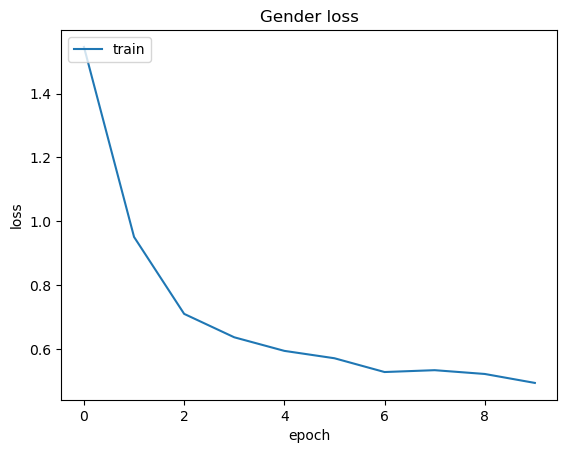

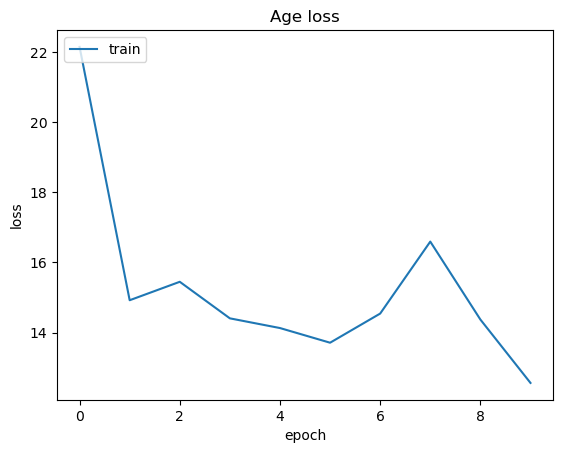

In [21]:
plt.plot(model_history.history['gender_output_loss'])
# plt.plot(model_history.history['val_gender_output_loss'])
plt.title('Gender loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(model_history.history['age_output_loss'])
# plt.plot(model_history.history['val_age_output_loss'])
plt.title('Age loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Original: Gender = Female, Age = 1.0


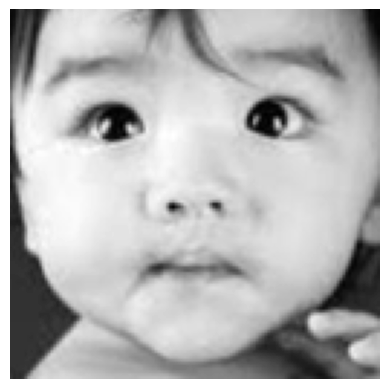

1/1 [==============================] - 0s 59ms/step
Prediction: Gender = Male, Age = 4


In [22]:
# index=28
# print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index])

# pred = model.predict(x_train[index].reshape(1, 128, 128, 1))
# pred_gender = gender_dict[round(pred[0][0][0])]
# pred_age = round(pred[1][0][0])

# print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
# plt.imshow(x_train[index].reshape(128,128), cmap='gray')

index = 22  # Index of the sample you want to test

# Fetch the image and true labels for the selected index
file_key = train['image'].iloc[index]
true_age = train['age'].iloc[index]
true_gender = gender_dict[train['gender'].iloc[index]]

# Fetch the image from S3 dynamically using s3_helper
img = s3_helper.get_img(f"UTKFace/{file_key}", greyscale=True)
img_resized = img.resize((128, 128), Image.LANCZOS)
img_array = np.array(img_resized).reshape(1, 128, 128, 1) / 255.0  # Normalize image

# Display original image and true labels
print(f"Original: Gender = {true_gender}, Age = {true_age}")
plt.imshow(np.squeeze(img_array), cmap='gray')
plt.axis('off')
plt.show()

# Make prediction using the model
pred = model.predict(img_array)
pred_gender = gender_dict[round(pred[0][0][0])]  # Predicted gender
pred_age = round(pred[1][0][0])  # Predicted age

# Display predictions
print(f"Prediction: Gender = {pred_gender}, Age = {pred_age}")
